In [1]:
!nvidia-smi

Fri Jan 16 18:59:45 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  |   00000000:2F:00.0 Off |                    0 |
| N/A   33C    P0             34W /  250W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import os
import numpy as np
import xarray as xr
import pickle
import glob
import warnings
from pathlib import Path, PureWindowsPath
import re

import cedalion
import cedalion.sigproc.motion as motion_correct
import cedalion.sigproc.quality as quality
import cedalion.sigproc.physio as physio
import cedalion.dot as dot
import cedalion.nirs as nirs
from cedalion.io.forward_model import load_Adot
from cedalion import units
import copy
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

In [3]:
def get_bad_ch_mask(int_data):
    # Saturated and Dark Channels

    dark_sat_thresh = [1e-3, 0.84]
    amp_threshs_sat = [0., dark_sat_thresh[1]]
    amp_threshs_low = [dark_sat_thresh[0], 1]
    _, amp_mask_sat = quality.mean_amp(int_data, amp_threshs_sat)
    _, amp_mask_low = quality.mean_amp(int_data, amp_threshs_low)
    _, snr_mask = quality.snr(int_data, 10)
    amp_mask=amp_mask_sat & amp_mask_low

    _, list_bad_ch = quality.prune_ch(int_data, [amp_mask, snr_mask], "all")
   
    return list_bad_ch

In [4]:

def standardize_trial_types(DATASET_NAME: str, file: str, rec):
    
    if DATASET_NAME == "FreshMotor":
        # map trial types to left or right depending on the name of the file
        m = re.search(r'(?i)(left|right)', file)

        # rename from MOTOR to left/right
        rec.stim.trial_type = m.group(1).lower()
    
    else:
        mapping = {
            "Right": "right", # BallSqueezingHD
            "Left": "left",   # BallSqueezingHD
            "ElectricalVAS7": "right", # TODO: Electrical_Thermal
            "ElectricalVAS3": "left",  # TODO: Electrical_Thermal
        }
        rec.stim["trial_type"] = rec.stim["trial_type"].replace(mapping)

    return rec

In [5]:
base_path = "/home/orabe/fNIRS_sparseToDense/"

# Available datasets:
# DATASET_NAME = "BallSqueezingHD_modified"
# DATASET_NAME = "FreshMotor"
DATASET_NAME = "BS_Laura"
# DATASET_NAME = "ElectricalThermal"

raw_path = Path(f'datasets/raw/{DATASET_NAME}')

pre_processed_path = Path(f'datasets/pre_processed/{DATASET_NAME}')
pre_processed_path.mkdir(parents=True, exist_ok=True)

In [6]:
if DATASET_NAME == "BallSqueezingHD_modified":
    raw_dir = f"{raw_path}/sub-*/nirs/sub-*.snirf"

elif DATASET_NAME == "BS_Laura":
    raw_dir = f"{raw_path}/sub-*/nirs/sub-*.snirf"
    
elif DATASET_NAME == "Electrical_Thermal":
    raw_dir = f"{raw_path}/sub-*/ses-*/nirs/sub-*_ses-*_task-Electrical*_nirs.snirf"
    # TODO: exclude subjects without txt files for landmarks coords
    
elif DATASET_NAME == "FreshMotor":
    duration = "*" # * to include both 2s and 3s
    raw_dir = f"{raw_path}/sub-*/ses-*{duration}/nirs/sub-*_ses-*{duration}_task-FRESHMOTOR_nirs.snirf"
else:
    raise ValueError("Unknown dataset name")

files = glob.glob(raw_dir)

# TODO: to be confirmed
# remove non-BS files for Laura's dataset to avoid errors
if DATASET_NAME == "BS_Laura":
    files = [p for p in files if "BS" in os.path.basename(p)]
    
files = sorted(files)
print(f"{len(files)} files found.")

63 files found.


In [7]:
filename = files[0] # select one
rec = cedalion.io.read_snirf(filename)[0]  # read snirf files
rec['amp']

Magnitude,[[[0.0014326959343035645 0.001500815307775305 0.0014592225712320682 ... 0.001496308354899103 0.0014612828925469035 0.0014968234352278117] [0.0023763230964981103 0.0024004031018652473 0.0023425853349676833 ... 0.0022645506651682978 0.002270216548784095 0.002272019329934576]] [[0.00021221309542803111 0.00021491726715375237 0.00022071192085172653 ... 0.00018156581586985671 0.00020551705115481655 0.00018439875767775518] [0.0004897126225199043 0.0004727149716725135 0.0005060664229564092 ... 0.00044915004663408526 0.0004697532597824378 0.000437560739238137]] [[0.08824832640743446 0.08818793323889336 0.08803044742839064 ... 0.08953744370011044 0.08961856885188209 0.08909975419079014] [0.12424007945629151 0.123779726412508 0.12344041724597107 ... 0.1215220005616951 0.1217987274682939 0.12077513408506732]] ... [[0.00014834313466813824 0.00020049501794990558 0.00020332795975780407 ... 0.00020564582123699373 0.00018774677981436247 0.00022998336676848517] [0.00037987174242274985 0.00045352822942811016 0.00046035304378350193 ... 0.00045906534296172996 0.00046485999665970407 0.0005079979741890671]] [[0.5678445137313333 0.5686293673822034 0.5685747688673602 ... 0.5506446938549243 0.5491338344807392 0.5491473553393678] [0.7577469047213421 0.7589617216766019 0.7586000065157661 ... 0.7378910731299462 0.7358441439036573 0.7355326490748707]] [[1e-06 1e-06 1e-06 ... 1e-06 1e-06 1.1975617642479892e-05] [1e-06 1e-06 1.3649628710783566e-05 ... 1e-06 1e-06 2.858695824333913e-05]]]
Units,dimensionless


In [46]:
filename

'datasets/raw/BS_Laura/sub-538/nirs/sub-538_task-BS_run-01_nirs.snirf'

In [ ]:
filename = files[0] # select one
rec = cedalion.io.read_snirf(filename)[0]  # read snirf files
meas_list = rec._measurement_lists["amp"]

head_icbm152 = dot.get_standard_headmodel('icbm152')  

# if DATASET_NAME == "BS_Laura":
#     # this is required for BU Data (Laura's)
#     T = np.array([
#         [-9.57882733e-01, -7.20806358e-03,  6.20193531e-03, 2.21208571e+02],
#         [-2.02271710e-02,  6.03819925e-02,  9.94046165e-01, -2.03010603e+01],
#         [-8.79481533e-03, -1.02761992e+00,  6.59199998e-02, 2.87749135e+02],
#         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, 1.00000000e+00]])
    
#     ninja_aligned = rec.geo3d.points.apply_transform(T)
#     geo3d_snapped_ijk = head_icbm152.align_and_snap_to_scalp(ninja_aligned)
# else:
geo3d_snapped_ijk = head_icbm152.align_and_snap_to_scalp(rec.geo3d)

fwm = cedalion.dot.forward_model.ForwardModel(
    head_icbm152, 
    geo3d_snapped_ijk,
    meas_list
)

fluence_fname = os.path.join(pre_processed_path, "fluence_" + DATASET_NAME + ".h5")
sensitivity_fname = os.path.join(pre_processed_path, "sensitivity_" + DATASET_NAME + ".h5")

# compute fluence and sensitivity only once
# fwm.compute_fluence_mcx(fluence_fname)
# fwm.compute_sensitivity(fluence_fname, sensitivity_fname)

Adot = load_Adot(sensitivity_fname)
recon = dot.ImageRecon(
    Adot,
    recon_mode="mua2conc",
    brain_only=True,
    alpha_meas=10,
    alpha_spatial=10e-3,
    apply_c_meas=True,
    spatial_basis_functions=None,
)

simulating fluence for S1. 1 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S2. 2 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S3. 3 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S4. 4 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S5. 5 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S6. 6 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S7. 7 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S8. 8 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S9. 9 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S10. 10 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S11. 11 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S12. 12 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S13. 13 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S14. 14 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S15. 15 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S16. 16 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S17. 17 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S18. 18 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S19. 19 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S20. 20 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S21. 21 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S22. 22 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S23. 23 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S24. 24 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S25. 25 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S26. 26 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S27. 27 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S28. 28 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S29. 29 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S30. 30 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S31. 31 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S32. 32 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S33. 33 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S34. 34 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S35. 35 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S36. 36 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S37. 37 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S38. 38 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S39. 39 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S40. 40 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S41. 41 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S42. 42 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S43. 43 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S44. 44 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S45. 45 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S46. 46 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S47. 47 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S48. 48 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S49. 49 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S50. 50 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S51. 51 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S52. 52 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S53. 53 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S54. 54 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S55. 55 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for S56. 56 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D1. 57 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D2. 58 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D3. 59 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D4. 60 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D5. 61 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D6. 62 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D7. 63 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D8. 64 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D9. 65 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D10. 66 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D11. 67 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D12. 68 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D13. 69 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D14. 70 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D15. 71 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D16. 72 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D17. 73 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D18. 74 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D19. 75 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D20. 76 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D21. 77 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D22. 78 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D23. 79 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D24. 80 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D25. 81 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D26. 82 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D27. 83 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D28. 84 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D29. 85 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D30. 86 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D31. 87 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D32. 88 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D33. 89 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D34. 90 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D35. 91 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D36. 92 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D37. 93 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D38. 94 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D39. 95 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D40. 96 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D41. 97 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D42. 98 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D43. 99 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D44. 100 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D45. 101 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D46. 102 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D47. 103 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D48. 104 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D49. 105 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D50. 106 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D51. 107 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D52. 108 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D53. 109 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D54. 110 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D55. 111 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D56. 112 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D57. 113 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D58. 114 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D59. 115 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D60. 116 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D61. 117 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D62. 118 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D63. 119 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D64. 120 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D65. 121 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D66. 122 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D67. 123 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D68. 124 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D69. 125 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D70. 126 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D71. 127 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D72. 128 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D73. 129 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D74. 130 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D75. 131 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D76. 132 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D77. 133 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D78. 134 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D79. 135 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D80. 136 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D81. 137 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D82. 138 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D83. 139 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D84. 140 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D85. 141 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D86. 142 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D87. 143 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D88. 144 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D89. 145 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D90. 146 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D91. 147 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D92. 148 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D93. 149 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D94. 150 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D95. 151 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D96. 152 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D97. 153 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D98. 154 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D99. 155 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D100. 156 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D101. 157 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D102. 158 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D103. 159 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D104. 160 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D105. 161 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D106. 162 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D107. 163 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D108. 164 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D109. 165 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D110. 166 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D111. 167 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D112. 168 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D113. 169 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D114. 170 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D115. 171 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D116. 172 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D117. 173 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D118. 174 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D119. 175 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D120. 176 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D121. 177 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D122. 178 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D123. 179 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D124. 180 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D125. 181 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D126. 182 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D127. 183 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D128. 184 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D129. 185 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D130. 186 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D131. 187 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D132. 188 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D133. 189 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D134. 190 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D135. 191 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D136. 192 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D137. 193 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D138. 194 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D139. 195 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D140. 196 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D141. 197 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D142. 198 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D143. 199 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

simulating fluence for D144. 200 / 200
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 0


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

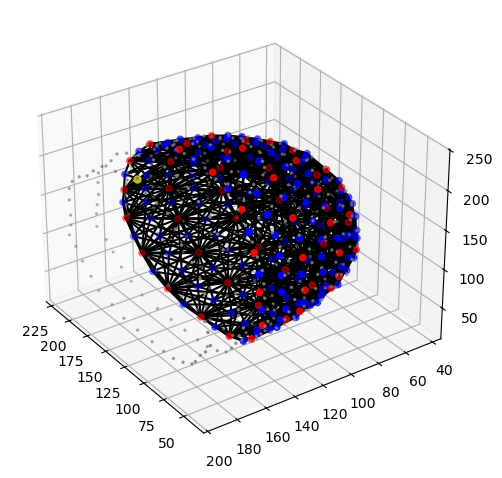

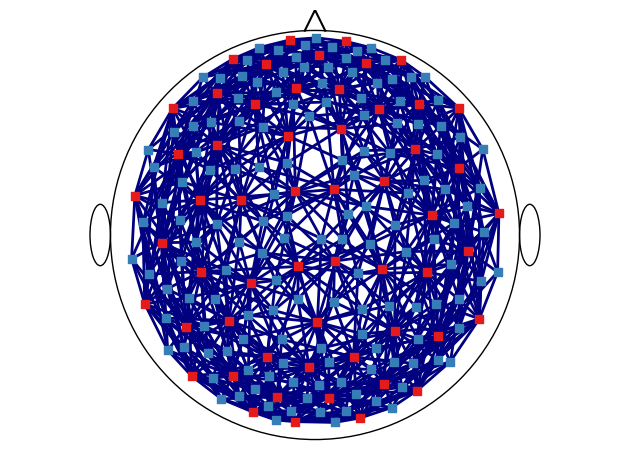

In [55]:
from cedalion.vis.anatomy import plot_montage3D

# use the plot_montage3D() function. It requires a recording container and a geo3d object
plot_montage3D(rec["amp"], rec.geo3d)

fig, ax = plt.subplots(1, 1)

cedalion.vis.anatomy.scalp_plot(
    rec['amp'],
    geo3d_snapped_ijk,
    np.ones(rec['amp'].channel.size),
    ax,
    cmap="jet",
    title="",
    vmin=1,
    vmax=1,
    cb_label="",
    add_colorbar=False,
)
plt.tight_layout()

In [56]:
# build sensitivity once
parcel_dOD, parcel_mask = fwm.parcel_sensitivity(
    Adot,
    [],  # bad channels list
    dOD_thresh=0.001,
    minCh=1,
    dHbO=10,
    dHbR=-3
)


In [57]:
parcel_dOD.shape

(2, 1220, 602)

In [35]:
rec['amp'].shape

(1220, 2, 3241)

In [58]:
# parcel_dOD dims: (wavelength, channel, parcel)

# reduce sensitivity across wavelength and parcel
w = np.abs(parcel_dOD).max("wavelength").max("parcel")

# keep top 10% sensitivity channels
keep_ch = w > w.quantile(0.95)
keep_channels = w.channel.values[keep_ch]


len(keep_channels)

61

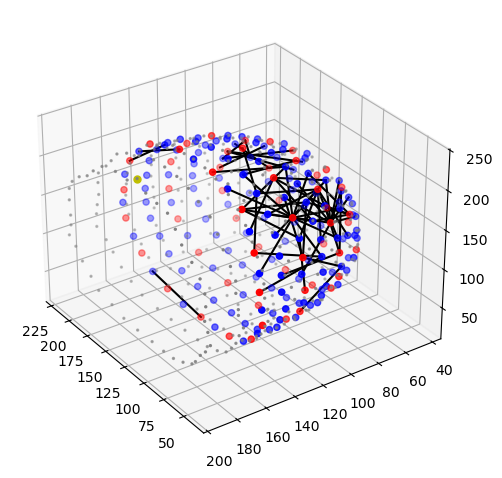

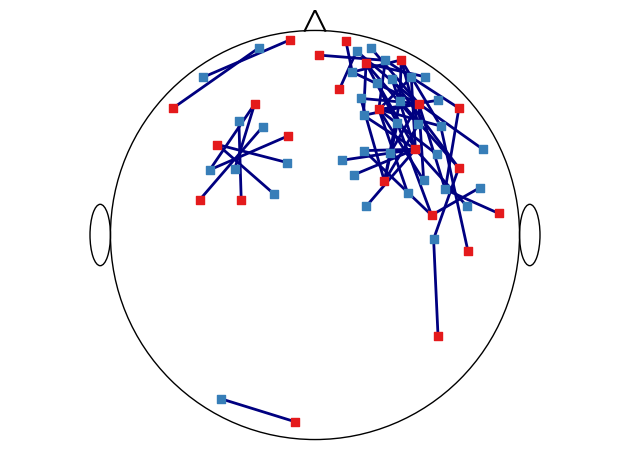

In [59]:
# plot after subsetting channels

rec_sub = copy.deepcopy(rec)
rec_sub['amp'] = rec['amp'].sel(channel=keep_channels)

plot_montage3D(rec_sub['amp'], rec_sub.geo3d)


fig, ax = plt.subplots(1, 1)

cedalion.vis.anatomy.scalp_plot(
    rec_sub['amp'],
    geo3d_snapped_ijk,
    np.ones(rec_sub['amp'].channel.size),
    ax,
    cmap="jet",
    title="",
    vmin=1,
    vmax=1,
    cb_label="",
    add_colorbar=False,
)
plt.tight_layout()

In [60]:
# 3) map to optodes (sources + detectors)
keep_sources = set(rec_sub['amp'].source.sel(channel=keep_channels).values)
keep_detectors = set(rec_sub['amp'].detector.sel(channel=keep_channels).values)
keep_optodes = keep_sources | keep_detectors

In [61]:
# 4) build mask for amp (channels)
mask = rec_sub['amp'].channel.isin(keep_channels)
rec_sub['amp'] = rec_sub['amp'].sel(channel=mask)


print("Kept channels:", len(keep_channels))
print("Kept optodes:", len(keep_optodes))

Kept channels: 61
Kept optodes: 60


In [62]:
# Approach 2

In [78]:
# parcel_dOD dims: (wavelength, channel, parcel)
sens_per_chs = np.abs(parcel_dOD).mean(dim="wavelength").max(dim="parcel")

# sort channels by sensitivity
sorted_idx = np.argsort(sens_per_chs.values)[::-1]
sorted_channels = sens_per_chs.channel.values[sorted_idx]
sorted_weights = sens_per_chs.values[sorted_idx]

# top N channels
N = 100
top_channels = sorted_channels[:N]
top_weights = sorted_weights[:N]

print(top_channels)


['S14D92' 'S9D87' 'S12D141' 'S10D107' 'S10D131' 'S12D135' 'S10D139'
 'S5D92' 'S15D138' 'S12D143' 'S10D137' 'S10D133' 'S56D8' 'S5D135'
 'S13D104' 'S16D85' 'S9D138' 'S9D90' 'S9D112' 'S52D141' 'S5D93' 'S52D96'
 'S11D84' 'S9D91' 'S8D142' 'S12D142' 'S10D83' 'S26D21' 'S2D143' 'S12D87'
 'S5D94' 'S14D96' 'S6D18' 'S10D132' 'S11D133' 'S13D137' 'S9D95' 'S20D90'
 'S4D138' 'S14D143' 'S52D94' 'S25D17' 'S6D8' 'S22D104' 'S10D135' 'S13D96'
 'S10D95' 'S15D85' 'S14D90' 'S1D2' 'S9D89' 'S42D62' 'S53D1' 'S12D136'
 'S12D86' 'S52D92' 'S12D140' 'S12D85' 'S11D94' 'S31D67' 'S26D22' 'S9D131'
 'S12D138' 'S12D83' 'S11D128' 'S14D34' 'S4D140' 'S13D136' 'S26D130'
 'S5D90' 'S29D40' 'S29D39' 'S5D141' 'S5D38' 'S9D129' 'S42D73' 'S56D40'
 'S14D139' 'S10D141' 'S54D17' 'S2D137' 'S26D20' 'S5D91' 'S2D67' 'S54D143'
 'S13D95' 'S8D96' 'S46D79' 'S9D142' 'S26D66' 'S6D72' 'S15D92' 'S4D66'
 'S32D36' 'S20D89' 'S6D35' 'S13D112' 'S3D5' 'S1D140' 'S56D3']


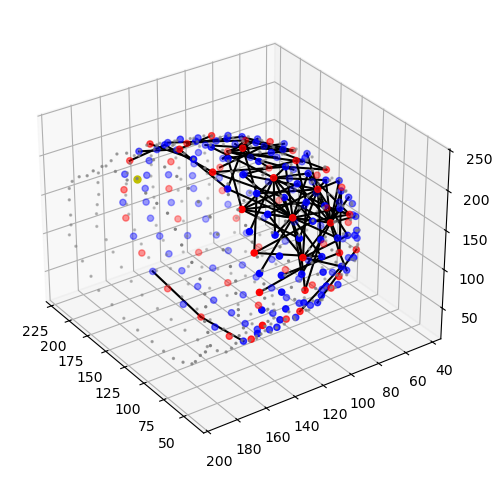

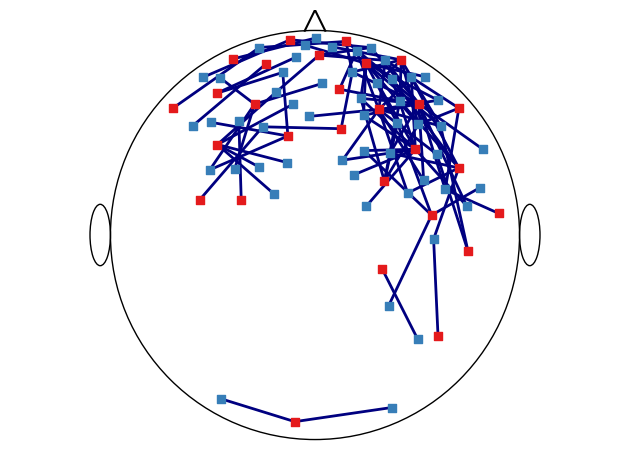

In [79]:
# plot after subsetting channels

rec_sub = copy.deepcopy(rec)
rec_sub['amp'] = rec['amp'].sel(channel=top_channels)

plot_montage3D(rec_sub['amp'], rec_sub.geo3d)


fig, ax = plt.subplots(1, 1)

cedalion.vis.anatomy.scalp_plot(
    rec_sub['amp'],
    geo3d_snapped_ijk,
    np.ones(rec_sub['amp'].channel.size),
    ax,
    cmap="jet",
    title="",
    vmin=1,
    vmax=1,
    cb_label="",
    add_colorbar=False,
)
plt.tight_layout()

In [8]:
subject_to_rec = {}
skipped_subjects = []

for f in files:
    records = cedalion.io.read_snirf(f)
    rec = records[0]

    rec.stim = rec.stim.sort_values(by="onset") ## Yuanyuan dataset

    rec['rep_amp'] = quality.repair_amp(rec['amp'], median_len=3, method='linear')  # Repair Amp
    rec['od_amp'], baseline= nirs.cw.int2od(rec['rep_amp'],return_baseline=True)

    # motion correct [TDDR + WAVELET]
    rec["od_tddr"] = motion_correct.tddr(rec["od_amp"])
    rec["od_tddr_wavel"] = motion_correct.wavelet(rec["od_tddr"])

    #-----------------------------------------highpass filter--------------------------------
    rec['od_hpfilt'] = rec['od_tddr_wavel'].cd.freq_filter(fmin=0.008,fmax=0,butter_order=4)
    #----------------------------------------------------------------------------------------

    # clean amplitude data
    rec['amp_clean'] = cedalion.nirs.cw.od2int(rec['od_hpfilt'], baseline)

    # get bad channel mask
    list_bad_ch = get_bad_ch_mask(rec["amp_clean"]) # this has custom paramerers!? 
    print('the list of bad channels: ', len(list_bad_ch))

    # channel variance
    od_var_vec = quality.measurement_variance(rec["od_hpfilt"], list_bad_channels=list_bad_ch, bad_rel_var=1e6,calc_covariance=False)

    #---------------------------------------------------------------------------------------
    dpf = xr.DataArray(
        [6, 6],
        dims="wavelength",
        coords={"wavelength": rec["amp"].wavelength},
    )
    rec['conc'] = cedalion.nirs.cw.od2conc(rec['od_hpfilt'], rec.geo3d, dpf, spectrum="prahl")

    # conc_pr vs conc 
    chromo_var = quality.measurement_variance(rec['conc'], list_bad_channels = list_bad_ch, bad_rel_var = 1e6, calc_covariance = False)
    rec['conc_pcr'], gb_comp_rem = physio.global_component_subtract(rec['conc'],ts_weights=1/chromo_var,k=0,spatial_dim='channel',spectral_dim='chromo')

    rec['od_pcr1'] = cedalion.nirs.cw.conc2od(rec['conc_pcr'], rec.geo3d, dpf, spectrum="prahl")#     delta_conc = chunked_eff_xr_matmult(od_stacked, B, contract_dim="flat_channel", sample_dim="time", chunksize=300)
    c_meas = quality.measurement_variance(rec['od_hpfilt'], list_bad_channels=list_bad_ch, bad_rel_var=1e6,calc_covariance=False)

    delta_conc = recon.reconstruct(rec['od_pcr1'], c_meas) 
    delta_conc.time.attrs["units"] = units.s

    dC_brain = delta_conc.cd.freq_filter(fmin=0.01, fmax=0.5, butter_order=4)
    dC_brain = dC_brain.sel(time=slice(rec.stim.onset.values[0]-3 , rec.stim.onset.values[-1]+13))
    dC_brain = dC_brain.where(dC_brain.is_brain == True)
    # alternatively use 1/conc_var to weight vertex sensitivity and then normalize by sum of weights
    dC_brain = dC_brain.pint.quantify().pint.to("uM").pint.dequantify()

    hbr = dC_brain.sel(chromo='HbR').groupby('parcel').mean()
    hbo = dC_brain.sel(chromo='HbO').groupby('parcel').mean()
    signal_raw = xr.concat([hbo, hbr], dim='chromo')

    # revised matrix
    signal_raw = signal_raw.sel(parcel=signal_raw.parcel != 'Background+FreeSurfer_Defined_Medial_Wall_LH')
    signal_raw = signal_raw.sel(parcel=signal_raw.parcel != 'Background+FreeSurfer_Defined_Medial_Wall_RH')
    
    delta_conc, global_comp = physio.global_component_subtract(
        signal_raw, 
        ts_weights=None, k=0, 
        spatial_dim='parcel',
        spectral_dim= 'chromo')

    delta_conc = delta_conc / np.abs(delta_conc).max()
    delta_conc = delta_conc.fillna(0)
    delta_conc = delta_conc.transpose("time", "parcel", "chromo")

    parcel_dOD, parcel_mask = fwm.parcel_sensitivity(
        Adot,
        [], # list_bad_ch,
        dOD_thresh = 0.001,       
        minCh=1,
        dHbO=10,
        dHbR=-3
    )
    sensitive_parcels = parcel_mask.where(parcel_mask, drop=True)["parcel"].values.tolist()
    dropped_parcels = parcel_mask.where(~parcel_mask, drop=True)["parcel"].values.tolist()
    print(f"Number of sensitive parcels: {len(sensitive_parcels)}")
    print(f"Number of dropped parcels: {len(dropped_parcels)}")
    
    rec = standardize_trial_types(DATASET_NAME, f, rec)
    
    data = {
        'conc_pcr': rec['conc_pcr'],
        'delta_conc': delta_conc,
        'rec_stim': rec.stim,
        'sensitive_parcels': sensitive_parcels,
    }
    
    # save as pickle (all parcels!!!)
    path = PureWindowsPath(f)
    subject_dir = path.parts[-3]
    filename = path.stem

    if DATASET_NAME == "FreshMotor":
        subject_dir = path.parts[-4]
        session_label = path.parts[-3]
        task_fragment = next(
            (part for part in filename.split('_') if part.startswith('task-')),
            f"task-{DATASET_NAME.replace('_', '').upper()}",
        )
        run_fragment = session_label.replace('ses-', 'run-')
        filename = f'{subject_dir}_{task_fragment}_{run_fragment}_nirs'

    if subject_dir not in subject_to_rec:
        subject_to_rec[subject_dir] = []

    all_parcels_dir = pre_processed_path / subject_dir
    all_parcels_dir.mkdir(parents=True, exist_ok=True)

    file_name_to_save = all_parcels_dir / f'{filename}.pkl'

    with open(file_name_to_save, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

if skipped_subjects:
    print(f"Skipped {len(skipped_subjects)} file(s) because all channels were bad.")

print("Processing complete.")

the list of bad channels:  7
Number of sensitive parcels: 110
Number of dropped parcels: 492
the list of bad channels:  7
Number of sensitive parcels: 110
Number of dropped parcels: 492
the list of bad channels:  17
Number of sensitive parcels: 110
Number of dropped parcels: 492
the list of bad channels:  17
Number of sensitive parcels: 110
Number of dropped parcels: 492
the list of bad channels:  17
Number of sensitive parcels: 110
Number of dropped parcels: 492
the list of bad channels:  6
Number of sensitive parcels: 110
Number of dropped parcels: 492
the list of bad channels:  6
Number of sensitive parcels: 110
Number of dropped parcels: 492
the list of bad channels:  5
Number of sensitive parcels: 110
Number of dropped parcels: 492
the list of bad channels:  2
Number of sensitive parcels: 110
Number of dropped parcels: 492
the list of bad channels:  2
Number of sensitive parcels: 110
Number of dropped parcels: 492
the list of bad channels:  2
Number of sensitive parcels: 110
Numbe

# Segmentation

In [36]:
# load (all) parcel files
preproc_files_path = str(pre_processed_path / 'sub-*' / '*.pkl')
proc_pkl_files = glob.glob(preproc_files_path)

len(proc_pkl_files), proc_pkl_files[:2]

(40,
 ['datasets/pre_processed/FreshMotor/sub-08/sub-08_task-FRESHMOTOR_run-right2s_nirs.pkl',
  'datasets/pre_processed/FreshMotor/sub-08/sub-08_task-FRESHMOTOR_run-right3s_nirs.pkl'])

In [37]:
processed_path = Path(f'datasets/processed/{DATASET_NAME}')
processed_path.mkdir(parents=True, exist_ok=True)

### Create template sensitive parcels

In [38]:
filename = 'datasets/pre_processed/FreshMotor/sub-08/sub-08_task-FRESHMOTOR_run-left2s_nirs.pkl'
with open(filename, 'rb') as handle:
    data = pickle.load(handle)

sh_filename2 = 'sensitive_parcels.pkl'
with open(sh_filename2, 'rb') as handle:
    shakiba = pickle.load(handle)

for sh in shakiba:
    if sh not in data['sensitive_parcels']:
        print(sh)
print(len(shakiba), len(data['sensitive_parcels']))

for p in data['sensitive_parcels']:
    if p not in shakiba:
        print(p)
        
c=0        
for p in data['sensitive_parcels']:
    if p in shakiba:
        c+=1       
print(c)

c=0
for sh in shakiba:
    if sh in data['sensitive_parcels']:
        c+=1       
print(c)

ContB_Temp_3_RH
DefaultB_Temp_1_RH
DefaultB_Temp_2_RH
DefaultB_Temp_5_LH
SalVentAttnA_ParOper_4_LH
SomMotB_Aud_1_LH
SomMotB_Aud_1_RH
SomMotB_Aud_2_LH
SomMotB_Aud_2_RH
SomMotB_S2_5_LH
SomMotB_S2_6_LH
SomMotB_S2_6_RH
SomMotB_S2_8_LH
TempPar_2_LH
TempPar_3_LH
TempPar_4_RH
104 180
ContA_IPS_4_RH
ContA_PFCd_1_LH
ContA_PFCd_2_LH
ContA_PFCl_1_LH
ContA_PFCl_1_RH
ContA_PFCl_2_LH
ContA_PFCl_3_RH
ContA_PFCl_4_LH
ContA_PFCl_6_RH
ContA_PFClv_2_LH
ContA_Temp_2_LH
ContB_IPL_2_RH
ContB_IPL_4_RH
ContB_PFCd_1_LH
ContB_PFCl_1_LH
ContB_PFCl_2_LH
ContB_PFCld_1_RH
ContB_PFCld_2_RH
ContB_PFCld_6_RH
ContB_PFCld_7_RH
DefaultA_IPL_1_LH
DefaultA_IPL_2_LH
DefaultA_IPL_2_RH
DefaultA_IPL_3_LH
DefaultA_IPL_3_RH
DefaultA_IPL_4_LH
DefaultA_IPL_4_RH
DefaultA_PFCd_1_RH
DefaultA_PFCd_2_LH
DefaultA_PFCd_3_LH
DefaultA_PFCd_3_RH
DefaultB_IPL_2_LH
DefaultB_IPL_4_LH
DefaultB_PFCd_6_LH
DefaultB_PFCv_5_RH
DefaultB_PFCv_7_LH
DefaultC_IPL_1_LH
DefaultC_IPL_1_RH
DefaultC_IPL_2_LH
DefaultC_IPL_2_RH
DefaultC_IPL_3_RH
DorsAttnA_ParOc

In [39]:
sens_parcel_yuanyuan_path = 'datasets/pre_processed/BallSqueezingHD_modified/parcel_template_BallSqueezingHD_modified.pkl'

with open(sens_parcel_yuanyuan_path, 'rb') as handle:
    template_sens_parcel_list = pickle.load(handle)

In [40]:
# if DATASET_NAME == "BallSqueezingHD_modified":
#     MAX_PARCELS = 0
#     PARCEL_TEMPLATE = None

#     for file in proc_pkl_files:
#         with open(file, 'rb') as handle:
#             data_pickle = pickle.load(handle)        
#         timeseries = data_pickle['delta_conc']
#         sensitive_parcels = data_pickle['sensitive_parcels']
        
#         sensitive_timeseries = timeseries.sel(parcel=sensitive_parcels)
        
#         if sensitive_timeseries.sizes["parcel"] > MAX_PARCELS:
#             MAX_PARCELS = sensitive_timeseries.sizes["parcel"]
#             PARCEL_TEMPLATE = sensitive_timeseries.parcel.values.tolist()
    
#     print(f"Max parcels across subjects: {MAX_PARCELS}")
#     print(f"Parcel template: {PARCEL_TEMPLATE}")

#     # Save the template parcels to pkl file
#     with open(f'{pre_processed_path}/parcel_template_{DATASET_NAME}.pkl', 'wb') as handle:
#         pickle.dump(PARCEL_TEMPLATE, handle, protocol=pickle.HIGHEST_PROTOCOL)      

In [ ]:
# if DATASET_NAME == "BallSqueezingHD_modified":
#     filename = 'datasets/pre_processed/BallSqueezingHD_modified/sub-173/sub-173_task-BallSqueezing_run-1_nirs.pkl'
#     with open(filename, 'rb') as handle:
#         data = pickle.load(handle)

#     with open(f'{pre_processed_path}/parcel_template_{DATASET_NAME}.pkl', 'wb') as handle:
#         pickle.dump(data['sensitive_parcels'], handle, protocol=pickle.HIGHEST_PROTOCOL)  

In [ ]:
# # For any dataset: load Pre-defined template parcel from BallSqueezingHD_modified file
# with open(f'{pre_processed_path.parents[0]}/BallSqueezingHD_modified/parcel_template_BallSqueezingHD_modified.pkl', 'rb') as handle:
#     PARCEL_TEMPLATE = pickle.load(handle)
# len(PARCEL_TEMPLATE)

In [24]:
baseline_duration = 2.5  # in seconds
n_shifts = 9
duration = 10  # in seconds
post_padding = 5  # in seconds
n_timepoints = 87  # fixed length after shifting

if DATASET_NAME == "BallSqueezingHD_modified":
    delta_range = (-2.5, 2.5)
elif DATASET_NAME == "FreshMotor":
    delta_range = (-2.0, 0.0)
start_shift = np.linspace(*delta_range, n_shifts)

    
for file in proc_pkl_files:
    with open(file, 'rb') as handle:
        data_pickle = pickle.load(handle)
    
    
    delta_brain = data_pickle['delta_conc']
    sensitive_parcels = data_pickle['sensitive_parcels']
    rec_stim = data_pickle['rec_stim']

    # Align subject-specific parcels to a common parcel template (zero-pad missing parcels)
    # delta_brain = delta_brain.sel(parcel=sensitive_parcels).reindex(parcel=PARCEL_TEMPLATE, fill_value=0)
    delta_brain = delta_brain.sel(parcel=template_sens_parcel_list)
    
    i = 0
    for index, row in rec_stim.iterrows():
        label = row["trial_type"].lower()
        for s in start_shift:
            start_time = row["onset"] + s
            end_time = start_time + duration + post_padding # in seconds
            baseline = delta_brain.sel(
                time=slice(row["onset"] - baseline_duration, row["onset"])
            ).mean("time")
            
            # Then, trimming is easy with `.sel()`:
            x = delta_brain.sel(time=slice(start_time, end_time)) - baseline
            x = x.isel(time=slice(0, n_timepoints))
            x = x.transpose("parcel", "chromo", "time")
            del x.time.attrs['units']

            if not os.path.exists(os.path.dirname(file.replace(str(pre_processed_path), str(processed_path)))):
                os.makedirs(os.path.dirname(file.replace(str(pre_processed_path), str(processed_path))))
            if s == 0:
                x.to_netcdf(file.replace(str(pre_processed_path), str(processed_path)).replace(".pkl", "_" + label + "_"+str(i)+"_test.nc"))
                i += 1
            else:
                x.to_netcdf(file.replace(str(pre_processed_path), str(processed_path)).replace(".pkl", "_" + label + "_"+str(i)+".nc"))
                i += 1

    print("finished processing file: ", os.path.basename(file).replace(".pkl",".npy"))
print('--- Done!---')            

finished processing file:  sub-08_task-FRESHMOTOR_run-right2s_nirs.npy
finished processing file:  sub-08_task-FRESHMOTOR_run-right3s_nirs.npy
finished processing file:  sub-08_task-FRESHMOTOR_run-left3s_nirs.npy
finished processing file:  sub-08_task-FRESHMOTOR_run-left2s_nirs.npy
finished processing file:  sub-04_task-FRESHMOTOR_run-left2s_nirs.npy
finished processing file:  sub-04_task-FRESHMOTOR_run-left3s_nirs.npy
finished processing file:  sub-04_task-FRESHMOTOR_run-right2s_nirs.npy
finished processing file:  sub-04_task-FRESHMOTOR_run-right3s_nirs.npy
finished processing file:  sub-06_task-FRESHMOTOR_run-left2s_nirs.npy
finished processing file:  sub-06_task-FRESHMOTOR_run-left3s_nirs.npy
finished processing file:  sub-06_task-FRESHMOTOR_run-right2s_nirs.npy
finished processing file:  sub-06_task-FRESHMOTOR_run-right3s_nirs.npy
finished processing file:  sub-03_task-FRESHMOTOR_run-right3s_nirs.npy
finished processing file:  sub-03_task-FRESHMOTOR_run-left2s_nirs.npy
finished proc

### channel space

In [ ]:
baseline_duration = 2.5  # in seconds
n_shifts = 9
duration = 10  # in seconds
post_padding = 5  # in seconds
n_timepoints = 87  # fixed length after shifting

if DATASET_NAME == "BallSqueezingHD_modified":
    delta_range = (-2.5, 2.5)
elif DATASET_NAME == "FreshMotor":
    delta_range = (-2.0, 0.0)
start_shift = np.linspace(*delta_range, n_shifts)

    
for file in proc_pkl_files:
    with open(file, 'rb') as handle:
        data_pickle = pickle.load(handle)
    
    
    rec_stim = data_pickle['rec_stim']
    conc_pcr = data_pickle['conc_pcr'] # channel space data

    # Align subject-specific parcels to a common parcel template (zero-pad missing parcels)
    # delta_brain = delta_brain.sel(parcel=sensitive_parcels).reindex(parcel=PARCEL_TEMPLATE, fill_value=0)
    
    i = 0
    for index, row in rec_stim.iterrows():
        label = row["trial_type"].lower()
        for s in start_shift:
            start_time = row["onset"] + s
            end_time = start_time + duration + post_padding # in seconds
            
            # channel space baseline
            baseline_conc_pcr = conc_pcr.sel(
                time=slice(row["onset"] - baseline_duration, row["onset"])
            ).mean("time")
        
            # channel space segment
            x_channel = conc_pcr.sel(time=slice(start_time, end_time)) - baseline_conc_pcr
            x_channel = x_channel.isel(time=slice(0, n_timepoints))
            x_channel = x_channel.transpose("channel", "chromo", "time")

            # print(x_channel.shape)
            del x_channel.time.attrs['units']
            if not os.path.exists(os.path.dirname(file.replace(str(pre_processed_path), str(processed_path)))):
                os.makedirs(os.path.dirname(file.replace(str(pre_processed_path), str(processed_path))))
            if s == 0:
                x_channel.to_netcdf(file.replace(str(pre_processed_path), str(processed_path)).replace(".pkl", "_" + label + "_"+str(i)+"_test.nc"))
                i += 1
            else:
                x_channel.to_netcdf(file.replace(str(pre_processed_path), str(processed_path)).replace(".pkl", "_" + label + "_"+str(i)+".nc"))
                i += 1

    print("finished processing file: ", os.path.basename(file).replace(".pkl",".npy"))
print('--- Done!---')            

(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68, 2, 87)
(68,

### Old appraoch using event files and freq0.5

FreshMotor

- parcel space: (parcel: 110, chromo: 2, time: 87)
- channel space: (time: 87, channel: 68, chromo: 2)

---
BallSqueezing

- parcel space: (parcel: 110, chromo: 2, time: 87)
- channel space: (channel: 100, chromo: 2, time: 87)


In [74]:
# FRESHMOTOR dataset
# load one processed nc file
filename = 'datasets/processed/FreshMotor/sub-01/sub-01_task-FRESHMOTOR_run-left2s_nirs_left_0.nc'
data = xr.load_dataset(filename)
    
# extract np array from xarray and remove first dimension
# data.to_array().squeeze().transpose("channel", "chromo", "time")
data

<xarray.Dataset> Size: 97kB
Dimensions:        (time: 87, channel: 68, chromo: 2)
Coordinates:
  * time           (time) float64 696B 59.14 59.25 59.36 ... 68.54 68.66 68.77
    samples        (time) int32 348B 528 529 530 531 532 ... 610 611 612 613 614
  * channel        (channel) object 544B 'S1D11' 'S1D12' ... 'S14D30' 'S14D31'
    source         (channel) object 544B 'S1' 'S1' 'S1' ... 'S14' 'S14' 'S14'
    detector       (channel) object 544B 'D11' 'D12' 'D15' ... 'D27' 'D30' 'D31'
  * chromo         (chromo) object 16B 'HbO' 'HbR'
Data variables:
    concentration  (channel, chromo, time) float64 95kB -0.02966 ... 0.129

In [66]:
type(data)
getattr(data, "dims", None)
[data[v].dims for v in data.data_vars]  # if Dataset



[('channel', 'chromo', 'time')]

# Outdated approach

In [ ]:
baseline_duration = 2.5  # in seconds
n_shifts = 9
duration = 10  # in seconds
post_padding = 5  # in seconds
n_timepoints = 87  # fixed length after shifting

if DATASET_NAME == "BallSqueezingHD_modified":
    delta_range = (-2.5, 2.5)
elif DATASET_NAME == "FreshMotor":
    delta_range = (-2.0, 0.0)
start_shift = np.linspace(*delta_range, n_shifts)






label_dict = {'right':1, 'left':2}  
subject_to_rec = {}            
INDEX = 0     
freq_dir = processed_path / f'frq{0.5}'
freq_dir.mkdir(exist_ok=True)       
for file in proc_pkl_files:
    with open(file, 'rb') as handle:
        data_pickle = pickle.load(handle)
    
    delta_brain = data_pickle['delta_conc']
    sensitive_parcels = data_pickle['sensitive_parcels']
    rec_stim = data_pickle['rec_stim']

    # Align subject-specific parcels to a common parcel template (zero-pad missing parcels)
    # delta_brain = delta_brain.sel(parcel=sensitive_parcels).reindex(parcel=PARCEL_TEMPLATE, fill_value=0)
    delta_brain = delta_brain.sel(parcel=template_sens_parcel_list)

    i = 0
    
    
    
    
    # ------
    SUB = PureWindowsPath(file).parts[-2]
    if SUB not in subject_to_rec:
        subject_to_rec[SUB] = []
    try:
        sub_dir = Path(freq_dir) / SUB
        sub_dir.mkdir(parents=True, exist_ok=True)
    except FileExistsError:
        pass
    # ------

    for index, row in rec_stim.iterrows():
        label = row["trial_type"].lower()
        for s in start_shift:
            start_time = row["onset"] + s
            end_time = start_time + duration + post_padding # in seconds
            baseline = delta_brain.sel(
                time=slice(row["onset"] - baseline_duration, row["onset"])
            ).mean("time")
            
            # Then, trimming is easy with `.sel()`:
            x = delta_brain.sel(time=slice(start_time, end_time)) - baseline
            x = x.isel(time=slice(0, n_timepoints))
            x = x.transpose("parcel", "chromo", "time")
            del x.time.attrs['units']

            data = {
                'xt': x,
                'file': file,
                'class': label_dict[label],
            }

            # -----
            # save events
            filename = r'{}/{}/event_{}_delta{:+.2f}_{}.pkl'.format(freq_dir, SUB, 'aug' if s != 0.0 else 'orig', s, INDEX)
            subject_to_rec[SUB].append(filename)
            INDEX += 1
            # -----
            
            
            # if not os.path.exists(os.path.dirname(file.replace(str(pre_processed_path), str(processed_path)))):
            #     os.makedirs(os.path.dirname(file.replace(str(pre_processed_path), str(processed_path))))
            # if s == 0:
            #     x.to_netcdf(file.replace(str(pre_processed_path), str(processed_path)).replace(".pkl", "_" + label + "_"+str(i)+"_test.nc"))
            #     i += 1
            # else:
            #     x.to_netcdf(file.replace(str(pre_processed_path), str(processed_path)).replace(".pkl", "_" + label + "_"+str(i)+".nc"))
            #     i += 1
            with open(filename, 'wb') as handle:
                pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
with open('{}/meta_event_{}.pkl'.format(freq_dir, 0.5), 'wb') as handle:
    pickle.dump(subject_to_rec, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('--- Done!---')            
    # print("finished processing file: ", os.path.basename(file).replace(".pkl",".npy"))

In [ ]:
events = "datasets/processed/{}/frq{}/meta_event_{}.pkl"
    
meta_events = []

with open(events.format(DATASET_NAME, 0.5, 0.5), 'rb') as handle:
    meta = pickle.load(handle)
meta_events.append(meta)


if DATASET_NAME == "BallSqueezingHD_modified":
    session_to_files = {'run-1':[],
                        'run-2':[],
                        'run-3':[]}
    
elif DATASET_NAME == "FreshMotor":    
    session_to_files = {'run-left2s':[],
                        'run-right2s':[],
                        'run-left3s':[],
                        'run-right3s':[]}

files_to_session = {}
for meta_event in meta_events:
    for sub in meta_event:
        for file in meta_event[sub]:
            meta = None
            with open(file, 'rb') as handle:
                meta = pickle.load(handle) 
            
            run = meta['file'].split('_')[-2]
            files_to_session[file] = run
            session_to_files[run].append(file)

for run in session_to_files:
    print(run, len(session_to_files[run]))

# this will save the mapping of files to sessions used for LOSO
with open(f'datasets/processed/{DATASET_NAME}/files_to_sessions.pkl', 'wb') as handle:
    pickle.dump(files_to_session, handle, protocol=pickle.HIGHEST_PROTOCOL)     
print("Saved files_to_sessions.pkl")